Tutorial: Classifying tiny images with a Convolutional Neural Network
======================================

Outline
------------------------
This interactive notebook shows how to do image classification with a Convnet. You can edit code in the code cells, and run it with `Shift+Return`. The notebook is read-only, so feel free to hack the code, and reload the page if something breaks. The tutorial covers how to:
* Build a small convNet in neon.
* Train it on the [Cifar10](https://www.kaggle.com/c/cifar-10) dataset. 
* Upload a new image, and classify it into one of the 10 categories.


<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3649/media/cifar-10.png">


Setting up a model
==================
The pieces we need to set up a model are described in the [neon user guide](http://neon.nervanasys.com/docs/latest/index.html):
* The CIFAR10 dataset.
* layer configuration and a  [model](http://neon.nervanasys.com/docs/latest/models.html).
* a compute [backend](http://neon.nervanasys.com/docs/latest/backends.html).
* an [optimizer](http://neon.nervanasys.com/docs/latest/optimizers.html) to train the model.
* [callbacks](http://neon.nervanasys.com/docs/latest/callbacks.html) to keep us updated about the progress of training.

In [1]:
# Start by generating the backend:
from neon.backends import gen_backend
be = gen_backend(backend='gpu',             
                 batch_size=128)

Loading a dataset
-----------------
More details about loading and generating datasets in our [documentation](http://neon.nervanasys.com/docs/latest/datasets.html).

In [2]:
# ImageLoader serves images with random crops and scaling. 
# To prepocess the data with batch_writer.py, run:
# batch_writer.py --set_type cifar10 --data_dir <path-to-save-batches>
#                 --macro_size 10000 --target_size 40
from neon.data import ImageLoader
imgset_options = dict(inner_size=32, scale_range=40, aspect_ratio=110,
                 repo_dir='/var/neon/data/cifar10', subset_pct=100)
train_set = ImageLoader(set_name='train', shuffle=True, 
                        do_transforms=True, **imgset_options)
test_set = ImageLoader(set_name='validation', shuffle=False, 
                       do_transforms=False, **imgset_options)


## Generating layers
The core of the model is the layers. This can be as simple as a list, but merging and branching makes it easy to specify complex topologies.

In [3]:
from neon.initializers import Uniform
from neon.transforms import Rectlin, Softmax
from neon.layers import Activation, Conv, Pooling, Affine, MergeSum

# This is a simple convnet with a one conv layer,
# max-pooling, and a fully connected layer. 
#
# input - Conv - ReLu - Pooling - Affine - ReLu - Affine - Softmax
#
layers = [Conv((5, 5, 16), init=Uniform(-0.1, 0.1), activation=Rectlin()),
          Pooling((2, 2)),
          Affine(nout=500, init=Uniform(-0.1, 0.1), activation=Rectlin()),
          Affine(nout=10, init=Uniform(-0.1, 0.1), activation=Softmax())]

# We can use a MergeSum layer to combine differnt layers in parallel
#
#             - Conv3 - ReLu - 
#           /                  \
# input   -                     Sum - ReLu - ...
#           \                  /
#             - Conv5 - ReLu - 
#
conv3 = Conv((3, 3, 16), init=Uniform(-0.1, 0.1), activation=Rectlin())
conv5 = Conv((5, 5, 16), padding=1, init=Uniform(-0.1, 0.1), activation=Rectlin())


layers = [MergeSum([conv3, conv5]), Activation(Rectlin()),
          Pooling((2, 2)),
          Affine(nout=500, init=Uniform(-0.1, 0.1), activation=Rectlin()),
          Affine(nout=10, init=Uniform(-0.1, 0.1), activation=Softmax())]

## The Deep Residual Network
A resnet module is a MergeSum layer containing a main path with conv layers, and a side path with a SkipNode() configured as the identity function. This allows earlier layer activations to bypass a series of layers.

We use some helper functions to succinclty define the deep network:

In [4]:
from neon.initializers import Kaiming, IdentityInit
from neon.layers import SkipNode
from neon.models import Model

# helper functions simplify init params for conv and identity layers
def conv_params(fsize, nfm, stride=1, relu=True, batch_norm=True):
    return dict(fshape=(fsize, fsize, nfm), 
                strides=stride, 
                padding=(1 if fsize > 1 else 0),
                activation=(Rectlin() if relu else None),
                init=Kaiming(local=True),
                batch_norm=batch_norm)

def id_params(nfm):
    return dict(fshape=(1, 1, nfm), 
                strides=2, 
                padding=0, 
                activation=None, 
                init=IdentityInit())

# A resnet module
#
#             - Conv - Conv - 
#           /                \
# input   -                   Sum - Relu - output
#           \               /
#            -  Identity - 
#
def module_factory(nfm, stride=1):
    mainpath = [Conv(**conv_params(3, nfm, stride=stride)),
                Conv(**conv_params(3, nfm, relu=False))]
    sidepath = [SkipNode() if stride == 1 else Conv(**id_params(nfm))]

    module = [MergeSum([mainpath, sidepath]),
              Activation(Rectlin())]
    return module

The model is a collection of resnet modules between an input conv and output pooling and affine layer.

In [5]:
# Set depth = 3 for quick results 
# or depth = 9 to reach 6.7% top1 error in 150 epochs
depth = 3
nfms = [2**(stage + 4) for stage in sorted(range(3) * depth)]
strides = [1] + [1 if cur == prev else 2 for cur, prev in zip(nfms[1:], nfms[:-1])]

layers = [Conv(**conv_params(3, 16))]
for nfm, stride in zip(nfms, strides):
    layers.append(module_factory(nfm, stride))
layers.append(Pooling('all', op='avg'))
layers.append(Affine(10, init=Kaiming(local=False), 
                     batch_norm=True, activation=Softmax()))
model = Model(layers=layers)

Cost function
--------------
The cost function compares network outputs with ground truth labels, and produces and error that we can backpropagate through the layers of the network.

For our binary classification task, we use a cross entropy cost function.

In [6]:
from neon.transforms import CrossEntropyMulti
from neon.layers import GeneralizedCost

cost = GeneralizedCost(costfunc=CrossEntropyMulti())

Optimizer
---------
We now have a cost function to minimize by gradient descent. We do this
iteratively over small batches of the data set, making it stochastic gradient 
decesent (SGD). There are other [optimizers](http://neon.nervanasys.com/docs/latest/optimizers.html) such as RMSProp and AdaDelta that are supported in neon, but often simple gradient descent works well.

In [7]:
from neon.optimizers import GradientDescentMomentum, Schedule

opt = GradientDescentMomentum(0.1, 0.9, wdecay=0.0001, 
                              schedule=Schedule([90, 135], 0.1))

Callbacks
---------
To provide feedback while the model is training, neon lets the user specify a set of callbacks that get evaluated at the end of every iteration (minibatch) or pass through the dataset (epoch). Callbacks include evaluating the model on a validation set or computing missclassification percentage. There are also callbacks for saving to disk and for generating visualizations. Here we will set up a progress bar to monitor training.

In [8]:
# set up callbacks. By default sets up a progress bar
from neon.transforms import Misclassification
from neon.callbacks.callbacks import Callbacks

valmetric = Misclassification()
callbacks = Callbacks(model, eval_set=test_set, metric=valmetric)


Training the model
------------------
Now all the pieces are in place to run the network. We use the fit function and pass it a dataset, cost, optmizer, and the callbacks we set up.

In [9]:
# And  run the model
epochs = 10
model.fit(train_set, optimizer=opt, num_epochs=epochs, 
          cost=cost, callbacks=callbacks)

Epoch 0   [Train |████████████████████|  391/391  batches, 1.20 cost, 42.29s]
Epoch 1   [Train |████████████████████|  391/391  batches, 1.01 cost, 42.32s]
Epoch 2   [Train |████████████████████|  390/390  batches, 0.84 cost, 42.26s]
Epoch 3   [Train |████████████████████|  391/391  batches, 0.75 cost, 42.30s]
Epoch 4   [Train |████████████████████|  391/391  batches, 0.70 cost, 42.28s]
Epoch 5   [Train |████████████████████|  390/390  batches, 0.62 cost, 42.20s]
Epoch 6   [Train |████████████████████|  391/391  batches, 0.59 cost, 42.22s]
Epoch 7   [Train |████████████████████|  390/390  batches, 0.54 cost, 42.12s]
Epoch 8   [Train |████████████████████|  391/391  batches, 0.57 cost, 42.22s]
Epoch 9   [Train |████████████████████|  391/391  batches, 0.53 cost, 42.21s]


Congrats! If you made it this far you have trained a convolutional network in neon.

Evaluating the model
--------------------
We can now compute the misclassification on the test set to see how well we did.

In [10]:
# Check the performance on the supplied test set
from neon.transforms import Misclassification

error_pct = 100 * model.eval(test_set, metric=Misclassification())
print 'Misclassification error = %.1f%%' % error_pct

Misclassification error = 20.2%


By increasing the depth of the network and the number of epochs, we can improve the performance to match state of the art.

This was quite a lot of code! Generally, to set up a new model from scratch it is best to follow one of the examples from the neon/examples directory. It's easy to mix and match parts!

Inference
=========
Now we want to grab a few new images from the internet and classify them through our network.

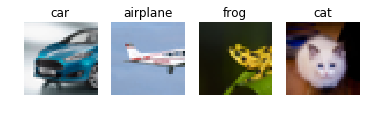

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib
from PIL import Image
import numpy as np

# download images from the web
imgs = {
       'frog': "https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Atelopus_zeteki1.jpg/440px-Atelopus_zeteki1.jpg",
       'airplane': "https://img0.etsystatic.com/016/0/5185796/il_570xN.433414910_p5n3.jpg",
       'cat': "https://s-media-cache-ak0.pinimg.com/236x/8e/d7/41/8ed7410285f101ba5892ff723c91fa75.jpg",
       'car': "http://static01.nyt.com/images/2012/09/09/automobiles/09REFI2/09REFI2-articleLarge.jpg",
       }

# empty buffer to use for inference dataset
# dims [minibatch, imgsize]
x_new = np.zeros((128, 32*32*3), dtype=np.float32)

# crop/resize images and assign them to slots in x_new
# also display with true labels
plt.figure(1)
for i, name in enumerate(imgs):
    imgs[name] = urllib.urlretrieve(imgs[name], filename="img/{}.jpg".format(name))
    plt.subplot(100 + (10 * len(imgs)) + 1 + i)

    img = Image.open("img/{}.jpg".format(name))
    crop = img.crop((0,0,min(img.size),min(img.size)))
    crop.thumbnail((32, 32))

    plt.imshow(crop, interpolation="nearest")
    plt.title(name)
    plt.axis('off')

    x_new[i,:] = np.asarray(crop, dtype=np.float32)[:,:,(2,0,1)].transpose(2,0,1).reshape(1,3072) -127


Create a dataset with this image for inference

In [13]:
from neon.data import ArrayIterator

# create a minibatch with the new image 
inference_set = ArrayIterator(x_new, None, nclass=10, 
                             lshape=(3, 32, 32))
# inference_set = ArrayIterator(x_train, None, nclass=10, 
#                              lshape=(3, 32, 32))
classes =["airplane", "auto", "bird", "cat", "deer", 
          "dog", "frog", "horse", "ship", "truck"]
out = model.get_outputs(inference_set)

Get model outputs on the inference data

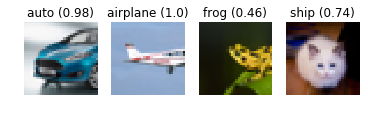

In [14]:
plt.figure(2)
for i, name in enumerate(imgs):
    plt.subplot(100 + (10 * len(imgs)) + 1 + i)

    img = Image.open("img/{}.jpg".format(name))
    crop = img.crop((0,0,min(img.size),min(img.size)))
    crop.thumbnail((32, 32))

    title = "{} ({:.2})".format(classes[out[i].argmax()], out[i].max())
        
    plt.imshow(crop, interpolation="nearest")
    plt.title(title)
    plt.axis('off')